<a href="https://colab.research.google.com/github/brendanbautista/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

Your target variable is *CATEGORY*, indicating if the air is healthy.  You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv (r'/content/daily_aqi_by_county_2023.zip')

Mounted at /content/gdrive


## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [4]:
#create columns
from sklearn.preprocessing import OneHotEncoder

# Step 1: Create dummy variables for the 'Defining Parameter'
defining_parameter_dummies = pd.get_dummies(df['Defining Parameter'], prefix='DefiningParam', drop_first=True)

# Step 2: Create variables for month and season
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Define the seasons based on the month
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else: # 9, 10, 11
        return 'Fall'

df['Season'] = df['Month'].apply(month_to_season)
season_dummies = pd.get_dummies(df['Season'], prefix='Season', drop_first=True)

# Step 3: Data cleanup
df_cleaned = df.dropna()
df_cleaned = df[(df['AQI'] > 0) & (df['AQI'] < 200)]


# Now merge the dummy variables back to the main dataframe
df_model = pd.concat([df_cleaned, defining_parameter_dummies, season_dummies], axis=1)

# Display the modified DataFrame to confirm changes
df_model.head()


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Season,DefiningParam_NO2,DefiningParam_Ozone,DefiningParam_PM10,DefiningParam_PM2.5,Season_Spring,Season_Summer,Season_Winter
0,Alabama,Baldwin,1.0,3.0,2023-01-10,35.0,Good,PM2.5,01-003-0010,1.0,1.0,Winter,0,0,0,1,0,0,1
1,Alabama,Baldwin,1.0,3.0,2023-01-11,28.0,Good,PM2.5,01-003-0010,1.0,1.0,Winter,0,0,0,1,0,0,1
2,Alabama,Baldwin,1.0,3.0,2023-01-12,23.0,Good,PM2.5,01-003-0010,1.0,1.0,Winter,0,0,0,1,0,0,1
3,Alabama,Baldwin,1.0,3.0,2023-01-13,18.0,Good,PM2.5,01-003-0010,1.0,1.0,Winter,0,0,0,1,0,0,1
4,Alabama,Baldwin,1.0,3.0,2023-01-14,20.0,Good,PM2.5,01-003-0010,1.0,1.0,Winter,0,0,0,1,0,0,1


In [5]:
#select final columns for
# Repeating the aggregation with the filtered data
df_cleaned['Month'] = df_cleaned['Date'].dt.month
df_cleaned['Season'] = df_cleaned['Month'].apply(month_to_season)

# Re-aggregate AQI by mean for each State, County, Month, and Season
df_monthly_mean_aqi_filtered = df_cleaned.groupby(['State Name', 'county Name', 'Month', 'Season']).agg(
    Mean_AQI=('AQI', 'mean'),
    Num_Sites_Reported=('Number of Sites Reporting', 'mean')
).reset_index()

<ipython-input-5-82862450e724>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Month'] = df_cleaned['Date'].dt.month
<ipython-input-5-82862450e724>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Season'] = df_cleaned['Month'].apply(month_to_season)


## Create Regression

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.
- Visualize the regression with at least one of the variables

In [6]:
#create regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


poly = PolynomialFeatures(degree=2, include_bias=False)


# Repeating the aggregation with the filtered data
df_cleaned['Month'] = df_cleaned['Date'].dt.month
df_cleaned['Season'] = df_cleaned['Month'].apply(month_to_season)

# Re-aggregate AQI by mean for each State, County, Month, and Season
df_monthly_mean_aqi_filtered = df_cleaned.groupby(['State Name', 'county Name', 'Month', 'Season']).agg(
    Mean_AQI=('AQI', 'mean'),
    Num_Sites_Reported=('Number of Sites Reporting', 'mean')
).reset_index()

# Re-include season dummies
df_monthly_mean_aqi_filtered = pd.concat([df_monthly_mean_aqi_filtered, pd.get_dummies(df_monthly_mean_aqi_filtered['Season'], prefix='Season', drop_first=True)], axis=1)

# Re-create polynomial features for 'Month'
X_poly_filtered = poly.fit_transform(df_monthly_mean_aqi_filtered[['Month']])
df_monthly_mean_aqi_filtered['Month_squared'] = X_poly_filtered[:,1]

# Prepare the data with the added polynomial feature for the filtered dataset
X_poly_features_filtered = df_monthly_mean_aqi_filtered[['Month', 'Month_squared', 'Num_Sites_Reported', 'Season_Spring', 'Season_Summer', 'Season_Winter']]
y_filtered = df_monthly_mean_aqi_filtered['Mean_AQI']

# Split the data into training and testing sets again
X_train_poly_filtered, X_test_poly_filtered, y_train_poly_filtered, y_test_poly_filtered = train_test_split(X_poly_features_filtered, y_filtered, test_size=0.2, random_state=42)

# Re-build and re-evaluate the model with the corrected dataset
model_poly_filtered = LinearRegression()
model_poly_filtered.fit(X_train_poly_filtered, y_train_poly_filtered)
y_pred_poly_filtered = model_poly_filtered.predict(X_test_poly_filtered)
r_squared_poly_filtered = r2_score(y_test_poly_filtered, y_pred_poly_filtered)
rmse_poly_filtered = np.sqrt(mean_squared_error(y_test_poly_filtered, y_pred_poly_filtered))

(r_squared_poly_filtered, rmse_poly_filtered)

<ipython-input-6-6c5bf65576f8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Month'] = df_cleaned['Date'].dt.month
<ipython-input-6-6c5bf65576f8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Season'] = df_cleaned['Month'].apply(month_to_season)


(0.21424009477007755, 14.051296037580284)

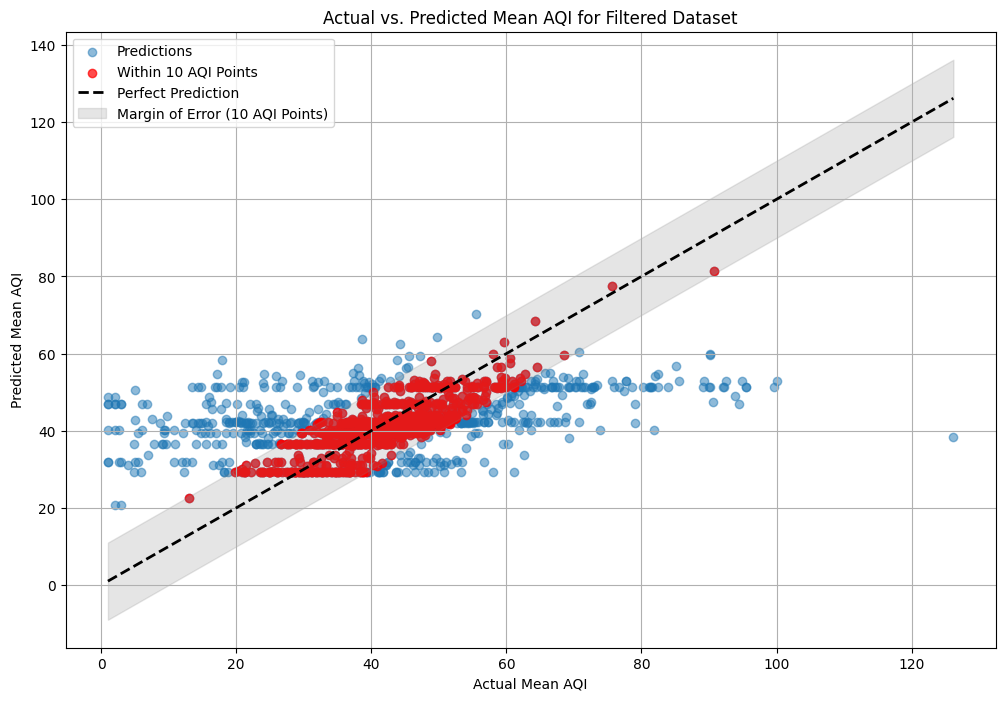

In [9]:
#visual
import matplotlib.pyplot as plt

# Define a margin for highlighting close predictions
margin_of_error = 10  # Arbitrary value for illustration; adjust based on model performance and goals

# Calculate the difference between actual and predicted values
diff = np.abs(y_test_poly_filtered - y_pred_poly_filtered)

# Create the enhanced visualization
plt.figure(figsize=(12, 8))
plt.scatter(y_test_poly_filtered, y_pred_poly_filtered, alpha=0.5, label='Predictions')

# Highlight predictions within the margin of error
within_margin = diff <= margin_of_error
plt.scatter(y_test_poly_filtered[within_margin], y_pred_poly_filtered[within_margin], color='red', alpha=0.7, label=f'Within {margin_of_error} AQI Points')

# Plot the perfect prediction line
plt.plot([y_test_poly_filtered.min(), y_test_poly_filtered.max()], [y_test_poly_filtered.min(), y_test_poly_filtered.max()], 'k--', lw=2, label='Perfect Prediction')

# Add shaded area for margin of error
plt.fill_between([y_test_poly_filtered.min(), y_test_poly_filtered.max()],
                 [y_test_poly_filtered.min() - margin_of_error, y_test_poly_filtered.max() - margin_of_error],
                 [y_test_poly_filtered.min() + margin_of_error, y_test_poly_filtered.max() + margin_of_error],
                 color='grey', alpha=0.2, label=f'Margin of Error ({margin_of_error} AQI Points)')

plt.xlabel('Actual Mean AQI')
plt.ylabel('Predicted Mean AQI')
plt.title('Actual vs. Predicted Mean AQI for Filtered Dataset')
plt.legend()
plt.grid(True)

plt.show()


## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

In [8]:
# Prepare the features for January
# Assuming an average 'Num_Sites_Reported' based on the dataset's overall mean for simplicity
num_sites_reported_avg = df_monthly_mean_aqi_filtered['Num_Sites_Reported'].mean()

# January is the 1st month, so Month=1, Month_squared=1^2=1
# Season_Winter=1, Season_Spring=0, Season_Summer=0 (Fall is the reference category and is thus excluded)
january_features = np.array([[1, 1, num_sites_reported_avg, 0, 0, 1]])

# Predict the average AQI for January
predicted_aqi_january = model_poly_filtered.predict(january_features)

predicted_aqi_january[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


30.795375951894098

## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [ ]:
#import, append and create new model